In [1]:
import numpy as np
from scipy import stats
from scipy import signal
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xscale

%matplotlib inline

## Define regression function 

In [2]:
def xarray_trend(xarr):
    """
    Calculates the trend of the data along the 'time' dimension
    of the input array (xarr).
    USAGE:  x_DS = xarray_trend(xarr)
    INPUT:  xarr is an xarray DataArray with dims:
                time, [lat, lon]
                where lat and/or lon are optional
    OUTPUT: xArray Dataset with:
                original xarr input
                slope
                p-value
    TODO?
    There could be speed improvements (using numpy at the moment)
    """

    from scipy import stats
    # getting shapes

    n = xarr.shape[0]

    # creating x and y variables for linear regression
    x = xarr.time.to_pandas().index.to_julian_date().values[:, None]
    y = xarr.to_masked_array().reshape(n, -1)

    # ############################ #
    # LINEAR REGRESSION DONE BELOW #
    xm = x.mean(0)  # mean
    ym = y.mean(0)  # mean
    ya = y - ym  # anomaly
    xa = x - xm  # anomaly

    # variance and covariances
    xss = (xa ** 2).sum(0) / (n - 1)  # variance of x (with df as n-1)
    yss = (ya ** 2).sum(0) / (n - 1)  # variance of y (with df as n-1)
    xys = (xa * ya).sum(0) / (n - 1)  # covariance (with df as n-1)
    # slope and intercept
    slope = xys / xss
    # statistics about fit
    df = n - 2
    r = xys / (xss * yss)**0.5
    t = r * (df / ((1 - r) * (1 + r)))**0.5
    p = stats.distributions.t.sf(abs(t), df)

    # misclaneous additional functions
    intercept = ym - (slope * xm)
    # yhat = dot(x, slope[None]) + intercept
    # sse = ((yhat - y)**2).sum(0) / (n - 2)  # n-2 is df
    # se = ((1 - r**2) * yss / xss / df)**0.5

    # preparing outputs
    out = xarr.to_dataset(name=xarr.name)
    # first create variable for slope and adjust meta
    out['slope'] = xarr[:2].mean('time').copy()
    out['slope'].name += '_slope'
    out['slope'].attrs['units'] = 'units / day'
    out['slope'].values = slope.reshape(xarr.shape[1:])
    # do the same for the p value
    out['pval'] = xarr[:2].mean('time').copy()
    out['pval'].name += '_Pvalue'
    out['pval'].values = p.reshape(xarr.shape[1:])
    out['pval'].attrs['info'] = ("If p < 0.05 then the results "
                                 "from 'slope' are significant.")
    # do the same for the intercept
    out['intercept'] = xarr[:2].mean('time').copy()
    out['intercept'].name += '_intercept'
    out['intercept'].values = intercept.reshape(xarr.shape[1:])
    

    return out

## Import netcdfs of CMC temperature at mooring locations made in Mooring_SST_subset.

In [3]:
MIS = xr.open_dataset('CMC_temp_MIS.nc')
BMP = xr.open_dataset('CMC_temp_BMP.nc')
SYD = xr.open_dataset('CMC_temp_SYD140.nc')
SRO = xr.open_dataset('CMC_temp_Seal_Rocks.nc')
CH = xr.open_dataset('CMC_temp_CH100.nc')
SEQ = xr.open_dataset('CMC_temp_SEQ200.nc')

# Should the box sizes for each mooring site be standardised?
MIS

<xarray.Dataset>
Dimensions:       (time: 9330)
Coordinates:
  * time          (time) datetime64[ns] 1991-09-01T12:00:00 ... 2017-03-17T12:00:00
Data variables:
    analysed_sst  (time) float32 ...

## Plot mooring locations

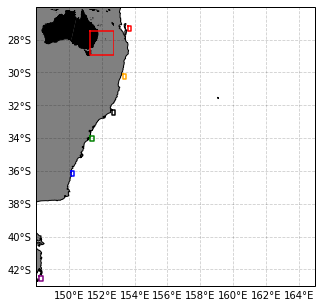

In [4]:
fig = plt.figure(figsize=(5,8))

coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')
roi = [148, 165, -43, -26]
ax2 = plt.axes(projection=ccrs.PlateCarree())
feature = ax2.add_feature(coast, edgecolor='black',facecolor='gray')

#im = ds.GSL.sel(TIME = '2019-04-12').plot(transform=ccrs.PlateCarree(),add_colorbar=False)
ax2.set_extent(roi)
gl = ax2.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_right = False
gl.xlabels_top = False

#SEQ
x = [153.6, 153.6, 153.8, 153.8, 153.6]
y = [-27.2, -27.5, -27.5, -27.2, -27.2]
ax2.plot(x, y, transform=ccrs.PlateCarree(),color = 'red')

#Coffs
x = [153.3, 153.3, 153.5, 153.5, 153.3]
y = [-30.1, -30.4, -30.4, -30.1, -30.1]
ax2.plot(x, y, transform=ccrs.PlateCarree(),color = 'orange')

#Seal Rocks
x = [152.6, 152.6, 152.8, 152.8, 152.6]
y = [-32.3, -32.6, -32.6, -32.3, -32.3]
ax2.plot(x, y, transform=ccrs.PlateCarree(),color = 'black')

#SYD
x = [151.3, 151.3, 151.5, 151.5, 151.3]
y = [-33.9, -34.2, -34.2, -33.9, -33.9]
ax2.plot(x, y, transform=ccrs.PlateCarree(),color = 'green')
#BMP
x = [150.1, 150.1, 150.3, 150.3, 150.1]
y = [-36, -36.3, -36.3, -36, -36]
ax2.plot(x, y, transform=ccrs.PlateCarree(),color = 'b')

#Maria Island
x = [148.2, 148.2, 148.4, 148.4, 148.2]
y = [-42.4, -42.7, -42.7, -42.4, -42.4]
ax2.plot(x, y, transform=ccrs.PlateCarree(),color = 'purple')


ax = fig.add_axes([.13,.59,.21,.21],projection=ccrs.PlateCarree())
ax.set_extent([110, 165, -45, -10])
feature = ax.add_feature(coast, edgecolor='black',facecolor='black')
 # to get the effect of having just the land without a map "background"
 # turn off the outline and background patches
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)

#x = [148, 148, 156, 156, 148]
#y = [-26, -38, -38, -26, -26]

x = [roi[0], roi[0], roi[1], roi[1], roi[0]]
y = [roi[3], roi[2], roi[2], roi[3], roi[3]]
ax.plot(x, y, transform=ccrs.PlateCarree(),color = 'red')

#plt.savefig('dipole_intro_map.eps', dpi=300,bbox_inches='tight')
plt.savefig('NSW_mooring_SST_map.png', dpi=300,bbox_inches='tight')
plt.show()

In [5]:
print(roi)

[148, 165, -43, -26]


## Remove seasonal cycle and filter

Stored 'BMP_T' (DataArray)


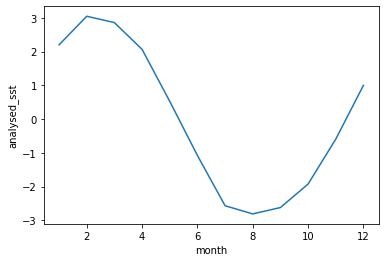

In [6]:
BMP_T = BMP.analysed_sst - 273.15 #convert from K to C
%store BMP_T
climatology = BMP_T.groupby('time.month').mean('time') - BMP_T.mean()
anomalies = BMP_T.groupby('time.month') - climatology
BMP_anomalies = anomalies
BMP_anomalies.to_netcdf('BMP_CMC_anomalies_processed.nc')
#filter with hanning window
wt = BMP_T.window
filt=730 # setting it here for all 3 cases
wt.set(n=filt, dim='time', window='hanning')
BMP_filt_anomalies = wt.convolve()

climatology.plot()

## Plot

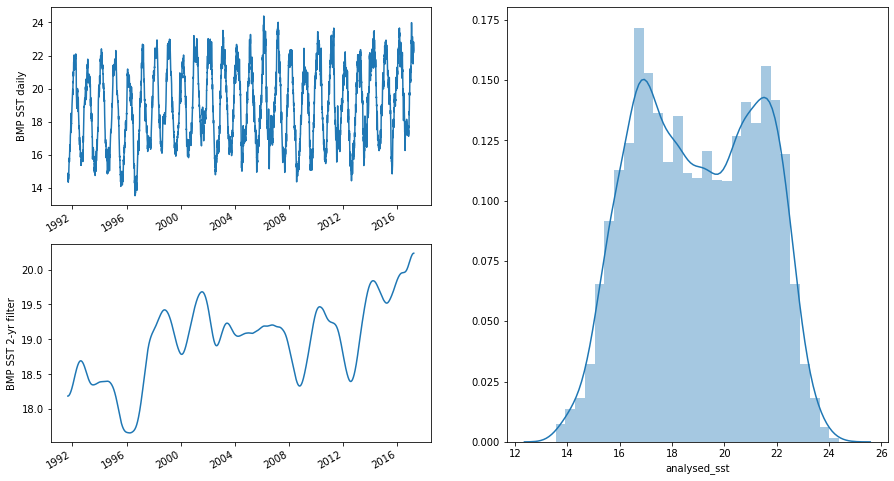

In [7]:
fig = plt.figure(figsize=[15,8])
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
BMP_T.plot(ax=ax1)
ax1.set_xlabel('')
ax1.set_ylabel('BMP SST daily')
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
BMP_filt_anomalies.plot()
ax2.set_xlabel('')
ax2.set_ylabel('BMP SST 2-yr filter')
ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
sns.distplot(BMP_T)
plt.savefig('BMP_mooring_SSTtseries.png', dpi=300,bbox_inches='tight')

### Get linear trend

In [8]:
trend_bmp = xarray_trend(BMP_T)
trend_bmp

<xarray.Dataset>
Dimensions:       (time: 9330)
Coordinates:
  * time          (time) datetime64[ns] 1991-09-01T12:00:00 ... 2017-03-17T12:00:00
Data variables:
    analysed_sst  (time) float32 14.86499 14.899994 ... 22.420013 22.194977
    slope         float64 0.0001354
    pval          float64 1.708e-52
    intercept     float64 -313.2

In [9]:
decade_trend_bmp = trend_bmp.slope*3650
decade_trend_bmp

<xarray.DataArray 'slope' ()>
array(0.49430707)

## Now do Sydney

Stored 'SYD_T' (DataArray)


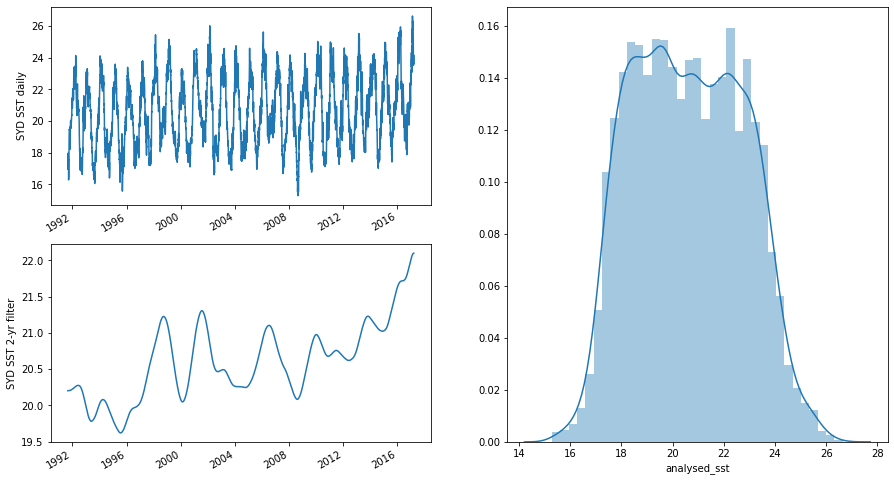

In [10]:
SYD_T = SYD.analysed_sst - 273.15 #convert from K to C
%store SYD_T
climatology = SYD_T.groupby('time.month').mean('time') - SYD_T.mean()
anomalies = SYD_T.groupby('time.month') - climatology
SYD_anomalies = anomalies 
SYD_anomalies.to_netcdf('SYD_CMC_anomalies_processed.nc')
#filter with hanning window
wt = SYD_T.window
filt=730 # setting it here for all 3 cases
wt.set(n=filt, dim='time', window='hanning')
SYD_filt_anomalies = wt.convolve()

fig = plt.figure(figsize=[15,8])
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
SYD_T.plot(ax=ax1)
ax1.set_xlabel('')
ax1.set_ylabel('SYD SST daily')
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
SYD_filt_anomalies.plot()
ax2.set_xlabel('')
ax2.set_ylabel('SYD SST 2-yr filter')
ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
sns.distplot(SYD_T)
plt.savefig('SYD_mooring_SSTtseries.png', dpi=300,bbox_inches='tight')

### Get linear trend

In [11]:
trend_syd = xarray_trend(SYD_T)
trend_syd

<xarray.Dataset>
Dimensions:       (time: 9330)
Coordinates:
  * time          (time) datetime64[ns] 1991-09-01T12:00:00 ... 2017-03-17T12:00:00
Data variables:
    analysed_sst  (time) float32 16.970001 16.98999 ... 23.850006 23.639984
    slope         float64 0.0001366
    pval          float64 3.844e-64
    intercept     float64 -314.6

In [12]:
decade_trend_syd = trend_syd.slope*3650
decade_trend_syd

<xarray.DataArray 'slope' ()>
array(0.49872984)

## Now do Seal Rocks

Stored 'SRO_T' (DataArray)


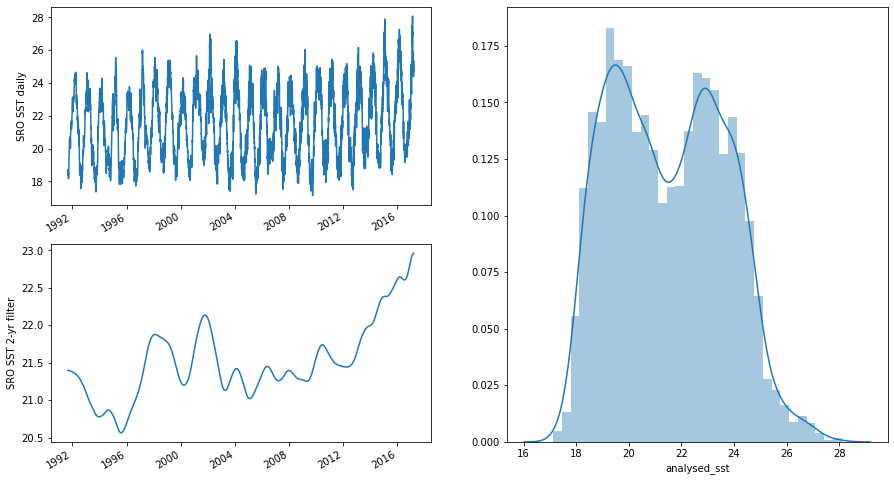

In [13]:
SRO_T = SRO.analysed_sst - 273.15 #convert from K to C
%store SRO_T
climatology = SRO_T.groupby('time.month').mean('time') - SRO_T.mean()
anomalies = SRO_T.groupby('time.month') - climatology
SRO_anomalies = anomalies 
SRO_anomalies.to_netcdf('SRO_CMC_anomalies_processed.nc')
#filter with hanning window
wt = SRO_T.window
filt=730 # setting it here for all 3 cases
wt.set(n=filt, dim='time', window='hanning')
SRO_filt_anomalies = wt.convolve()

fig = plt.figure(figsize=[15,8])
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
SRO_T.plot(ax=ax1)
ax1.set_xlabel('')
ax1.set_ylabel('SRO SST daily')
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
SRO_filt_anomalies.plot()
ax2.set_xlabel('')
ax2.set_ylabel('SRO SST 2-yr filter')
ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
sns.distplot(SRO_T)
plt.savefig('SRO_mooring_SSTtseries.png', dpi=300,bbox_inches='tight')

### Get linear trend


In [14]:
trend_sro = xarray_trend(SRO_T)
trend_sro

<xarray.Dataset>
Dimensions:       (time: 9330)
Coordinates:
  * time          (time) datetime64[ns] 1991-09-01T12:00:00 ... 2017-03-17T12:00:00
Data variables:
    analysed_sst  (time) float32 18.63501 18.644989 ... 24.76001 24.695007
    slope         float64 0.0001222
    pval          float64 6.745e-51
    intercept     float64 -278.3

In [15]:
decade_trend_sro = trend_sro.slope*3650
decade_trend_sro

<xarray.DataArray 'slope' ()>
array(0.44614222)

## And Coffs

Stored 'CH_T' (DataArray)


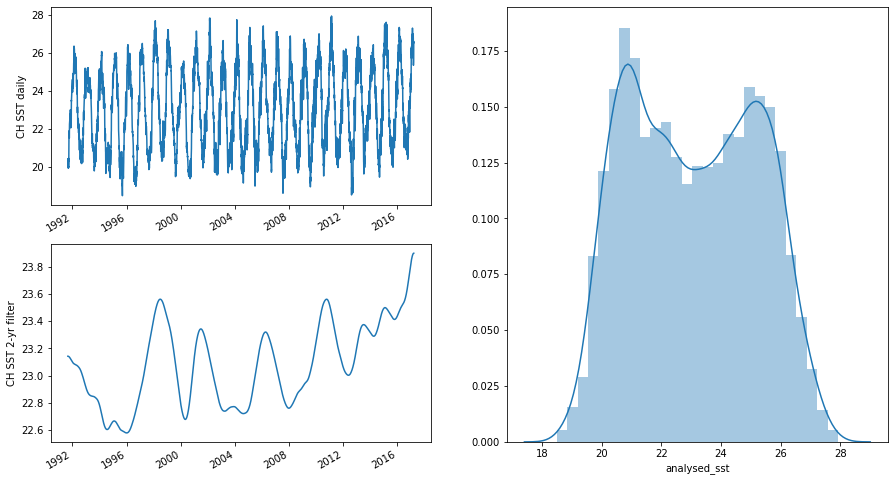

In [16]:
CH_T = CH.analysed_sst - 273.15 #convert from K to C
%store CH_T
climatology = CH_T.groupby('time.month').mean('time') - CH_T.mean()
anomalies = CH_T.groupby('time.month') - climatology
CH_anomalies = anomalies
CH_anomalies.to_netcdf('CH_CMC_anomalies_processed.nc')
#filter with hanning window
wt = CH_T.window
wt.set(n=filt, dim='time', window='hanning')
CH_filt_anomalies = wt.convolve()
fig = plt.figure(figsize=[15,8])
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
CH_T.plot(ax=ax1)
ax1.set_xlabel('')
ax1.set_ylabel('CH SST daily')
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
CH_filt_anomalies.plot()
ax2.set_xlabel('')
ax2.set_ylabel('CH SST 2-yr filter')
ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
sns.distplot(CH_T)
plt.savefig('CH_mooring_SSTtseries.png', dpi=300,bbox_inches='tight')

### get linear trend

In [17]:
trend_ch = xarray_trend(CH_T)
trend_ch

<xarray.Dataset>
Dimensions:       (time: 9330)
Coordinates:
  * time          (time) datetime64[ns] 1991-09-01T12:00:00 ... 2017-03-17T12:00:00
Data variables:
    analysed_sst  (time) float32 19.985016 20.005005 ... 26.595001 26.519989
    slope         float64 6.221e-05
    pval          float64 1.055e-14
    intercept     float64 -129.5

In [18]:
len(CH_T.time)

9330

In [19]:
decade_trend_ch = trend_ch.slope*3650
decade_trend_ch

<xarray.DataArray 'slope' ()>
array(0.22705189)

## Now do SE Queensland

Stored 'SEQ_T' (DataArray)


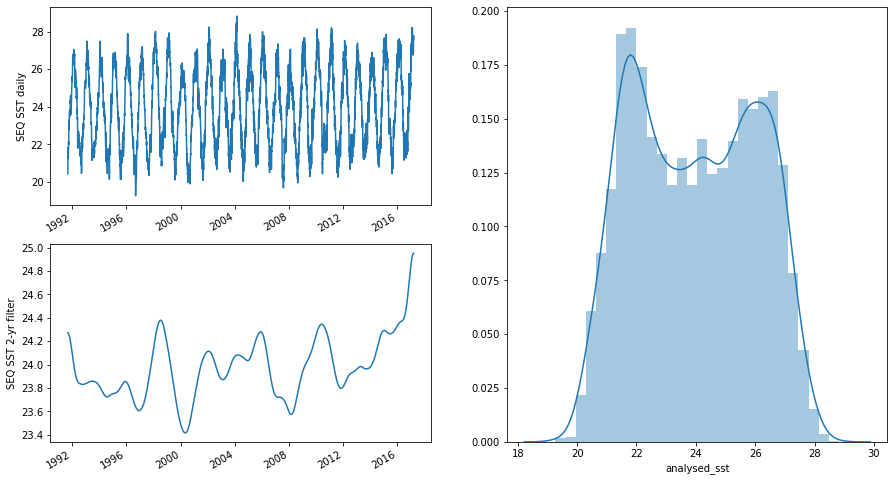

In [20]:
SEQ_T = SEQ.analysed_sst - 273.15 #convert from K to C
%store SEQ_T
climatology = SEQ_T.groupby('time.month').mean('time') - SEQ_T.mean()
anomalies = SEQ_T.groupby('time.month') - climatology
SEQ_anomalies = anomalies 
SEQ_anomalies.to_netcdf('SEQ_CMC_anomalies_processed.nc')
#filter with hanning window
wt = SEQ_T.window
filt=730 # setting it here for all 3 cases
wt.set(n=filt, dim='time', window='hanning')
SEQ_filt_anomalies = wt.convolve()

fig = plt.figure(figsize=[15,8])
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
SEQ_T.plot(ax=ax1)
ax1.set_xlabel('')
ax1.set_ylabel('SEQ SST daily')
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
SEQ_filt_anomalies.plot()
ax2.set_xlabel('')
ax2.set_ylabel('SEQ SST 2-yr filter')
ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
sns.distplot(SEQ_T)
plt.savefig('SEQ_mooring_SSTtseries.png', dpi=300,bbox_inches='tight')

## get linear trend

In [21]:
trend_seq = xarray_trend(SEQ_T)
trend_seq

<xarray.Dataset>
Dimensions:       (time: 9330)
Coordinates:
  * time          (time) datetime64[ns] 1991-09-01T12:00:00 ... 2017-03-17T12:00:00
Data variables:
    analysed_sst  (time) float32 20.434998 20.459991 ... 27.779999 27.569977
    slope         float64 4.512e-05
    pval          float64 5.677e-09
    intercept     float64 -86.73

In [22]:
decade_trend_seq = trend_seq.slope*3650
decade_trend_seq

<xarray.DataArray 'slope' ()>
array(0.16470434)

## as well as Maria Island

Stored 'MIS_T' (DataArray)


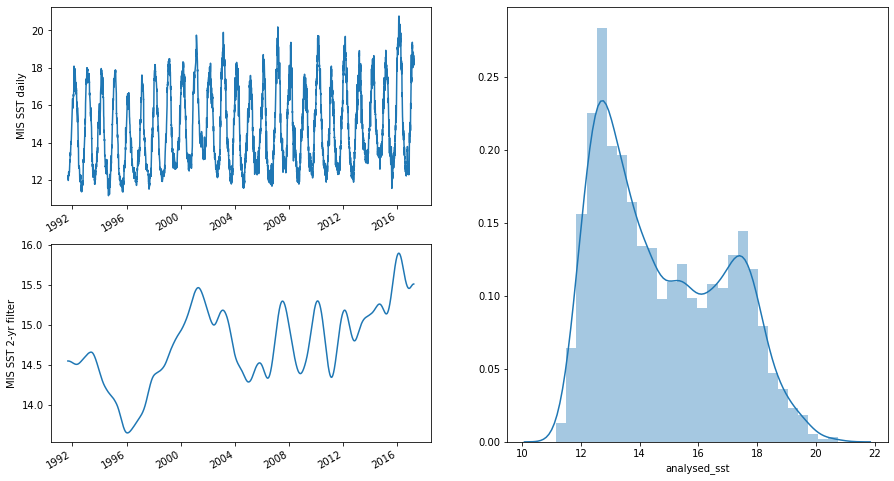

In [23]:
MIS_T = MIS.analysed_sst - 273.15 #convert from K to C
%store MIS_T
climatology = MIS_T.groupby('time.month').mean('time') - MIS_T.mean()
anomalies = MIS_T.groupby('time.month') - climatology
MIS_anomalies = anomalies 
MIS_anomalies.to_netcdf('MIS_CMC_anomalies_processed.nc')
#filter with hanning window
wt = MIS_T.window
filt=730 # setting it here for all 3 cases
wt.set(n=filt, dim='time', window='hanning')
MIS_filt_anomalies = wt.convolve()

fig = plt.figure(figsize=[15,8])
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
MIS_T.plot(ax=ax1)
ax1.set_xlabel('')
ax1.set_ylabel('MIS SST daily')
ax2 = plt.subplot2grid((2, 2), (1, 0), colspan=1)
MIS_filt_anomalies.plot()
ax2.set_xlabel('')
ax2.set_ylabel('MIS SST 2-yr filter')
ax3 = plt.subplot2grid((2, 2), (0, 1), rowspan=2)
sns.distplot(MIS_T)
plt.savefig('MIS_mooring_SSTtseries.png', dpi=300,bbox_inches='tight')

## get linear trend

In [24]:
trend_mis = xarray_trend(MIS_T)
trend_mis

<xarray.Dataset>
Dimensions:       (time: 9330)
Coordinates:
  * time          (time) datetime64[ns] 1991-09-01T12:00:00 ... 2017-03-17T12:00:00
Data variables:
    analysed_sst  (time) float32 12.204987 12.225006 ... 18.225006 18.204987
    slope         float64 0.0001155
    pval          float64 3.494e-46
    intercept     float64 -268.7

In [25]:
decade_trend_mis = trend_mis.slope*3650
decade_trend_mis

<xarray.DataArray 'slope' ()>
array(0.42170642)

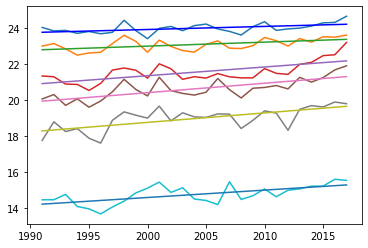

In [26]:
SEQ_annual_means = SEQ_anomalies.groupby('time.year').mean('time')

#use earl's method for plotting trendline:
sst_SEQ_slope, sst_SEQ_intercept, sst_SEQ_rvalue, sst_SEQ_pvalue, sst_SEQ_stderr = stats.linregress(SEQ_annual_means.year, SEQ_annual_means)
plt.plot(SEQ_annual_means.year,SEQ_annual_means)
x_SEQ = [SEQ_annual_means.year.isel(year=0), SEQ_annual_means.year.isel(year=-1)]

# slope * x + intercept
y_SEQ = [sst_SEQ_slope*x_SEQ[0] + sst_SEQ_intercept, sst_SEQ_slope*x_SEQ[1] + sst_SEQ_intercept]
plt.plot(x_SEQ,y_SEQ, color='blue')

CH_annual_means = CH_anomalies.groupby('time.year').mean('time')

#use earl's method for plotting trendline:
sst_CH_slope, sst_CH_intercept, sst_CH_rvalue, sst_CH_pvalue, sst_CH_stderr = stats.linregress(CH_annual_means.year, CH_annual_means)
plt.plot(CH_annual_means.year,CH_annual_means)
x_CH = [CH_annual_means.year.isel(year=0), CH_annual_means.year.isel(year=-1)]

# slope * x + intercept
y_CH = [sst_CH_slope*x_CH[0] + sst_CH_intercept, sst_CH_slope*x_CH[1] + sst_CH_intercept]
plt.plot(x_CH,y_CH)

SRO_annual_means = SRO_anomalies.groupby('time.year').mean('time')

#use earl's method for plotting trendline:
sst_SRO_slope, sst_SRO_intercept, sst_SRO_rvalue, sst_SRO_pvalue, sst_SRO_stderr = stats.linregress(SRO_annual_means.year, SRO_annual_means)
plt.plot(SRO_annual_means.year,SRO_annual_means)
x_SRO = [SRO_annual_means.year.isel(year=0), SRO_annual_means.year.isel(year=-1)]

# slope * x + intercept
y_SRO = [sst_SRO_slope*x_SRO[0] + sst_SRO_intercept, sst_SRO_slope*x_SRO[1] + sst_SRO_intercept]
plt.plot(x_SRO,y_SRO)

SYD_annual_means = SYD_anomalies.groupby('time.year').mean('time')

#use earl's method for plotting trendline:
sst_SYD_slope, sst_SYD_intercept, sst_SYD_rvalue, sst_SYD_pvalue, sst_SYD_stderr = stats.linregress(SYD_annual_means.year, SYD_annual_means)
plt.plot(SYD_annual_means.year,SYD_annual_means)
x_SYD = [SYD_annual_means.year.isel(year=0), SYD_annual_means.year.isel(year=-1)]

# slope * x + intercept
y_SYD = [sst_SYD_slope*x_CH[0] + sst_SYD_intercept, sst_SYD_slope*x_CH[1] + sst_SYD_intercept]
plt.plot(x_SYD,y_SYD)

BMP_annual_means = BMP_anomalies.groupby('time.year').mean('time')

#use earl's method for plotting trendline:
sst_BMP_slope, sst_BMP_intercept, sst_BMP_rvalue, sst_BMP_pvalue, sst_BMP_stderr = stats.linregress(BMP_annual_means.year, BMP_annual_means)
plt.plot(BMP_annual_means.year,BMP_annual_means)
x_BMP = [BMP_annual_means.year.isel(year=0), BMP_annual_means.year.isel(year=-1)]

# slope * x + intercept
y_BMP = [sst_BMP_slope*x_CH[0] + sst_BMP_intercept, sst_BMP_slope*x_CH[1] + sst_BMP_intercept]
plt.plot(x_BMP,y_BMP)

MIS_annual_means = MIS_anomalies.groupby('time.year').mean('time')

#use earl's method for plotting trendline:
sst_MIS_slope, sst_MIS_intercept, sst_MIS_rvalue, sst_MIS_pvalue, sst_MIS_stderr = stats.linregress(MIS_annual_means.year, MIS_annual_means)
plt.plot(MIS_annual_means.year,MIS_annual_means)
x_MIS = [MIS_annual_means.year.isel(year=0), MIS_annual_means.year.isel(year=-1)]

# slope * x + intercept
y_MIS = [sst_MIS_slope*x_CH[0] + sst_MIS_intercept, sst_MIS_slope*x_CH[1] + sst_MIS_intercept]
plt.plot(x_MIS,y_MIS)

## Now plot the filtered, processed data onto a single plot.

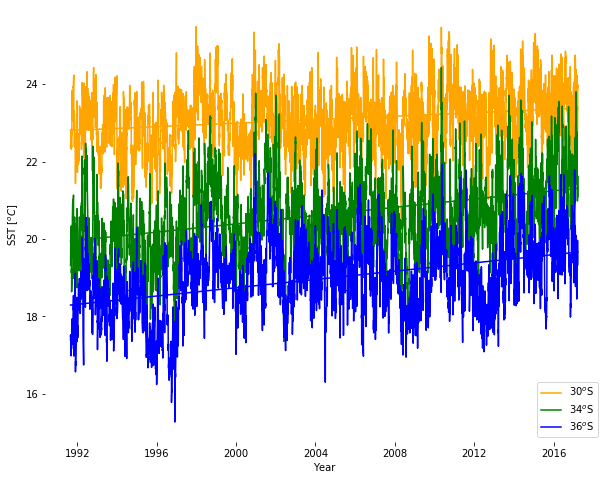

In [27]:
fig = plt.figure(figsize=[10,8])
ax=fig.add_subplot(1,1,1)
a = plt.plot(CH.time ,CH_anomalies, label='30$^o$S', color='orange')
plt.plot([CH.time[0].values,CH.time[-1].values],y_CH,color='orange')
b = plt.plot(SYD.time ,SYD_anomalies, label='34$^o$S',color='green')
plt.plot([SYD.time[0].values,SYD.time[-1].values],y_SYD,color='green')
c = plt.plot(BMP.time ,BMP_anomalies, label='36$^o$S',color='b')
plt.plot([BMP.time[0].values,BMP.time[-1].values],y_BMP,color='b')
plt.ylabel('SST [$^oC$]')
plt.xlabel('Year')
plt.box(False)
ax.legend(loc = 'lower right')





In [28]:
print(decade_trend_ch)
print(decade_trend_syd)
print(decade_trend_bmp)

<xarray.DataArray 'slope' ()>
array(0.22705189)
<xarray.DataArray 'slope' ()>
array(0.49872984)
<xarray.DataArray 'slope' ()>
array(0.49430707)


## Use the store magic to import mooring temperatures

Unable to restore variable 'BMP_120_surf', ignoring (use %store -d to forget!)
The error was: <class 'KeyError'>


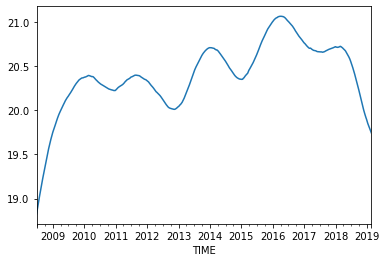

In [29]:
%store -r
SYD140_surface_raw.plot()
plt.show()

## Now plot it all together

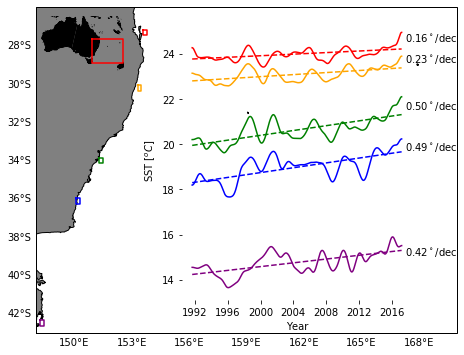

In [36]:
fig = plt.figure(figsize=(8,6))

coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',
                            facecolor='none', name='coastline')
roi = [148, 170, -43, -26]
ax2 = plt.axes(projection=ccrs.PlateCarree())
feature = ax2.add_feature(coast, edgecolor='black',facecolor='gray')

#im = ds.GSL.sel(TIME = '2019-04-12').plot(transform=ccrs.PlateCarree(),add_colorbar=False)
ax2.set_extent(roi)
gl = ax2.gridlines(draw_labels=True,
             color='black', alpha=0.2, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabels_right = False
gl.xlabels_top = False
gl.xlines = False
gl.ylines = False
#SEQ
x = [153.6, 153.6, 153.8, 153.8, 153.6]
y = [-27.2, -27.5, -27.5, -27.2, -27.2]
ax2.plot(x, y, transform=ccrs.PlateCarree(),color = 'red')

#Coffs
x = [153.3, 153.3, 153.5, 153.5, 153.3]
y = [-30.1, -30.4, -30.4, -30.1, -30.1]
ax2.plot(x, y, transform=ccrs.PlateCarree(),color = 'orange')

# #Seal Rocks
# x = [152.6, 152.6, 152.8, 152.8, 152.6]
# y = [-32.3, -32.6, -32.6, -32.3, -32.3]
# ax2.plot(x, y, transform=ccrs.PlateCarree(),color = 'black')

#SYD
x = [151.3, 151.3, 151.5, 151.5, 151.3]
y = [-33.9, -34.2, -34.2, -33.9, -33.9]
ax2.plot(x, y, transform=ccrs.PlateCarree(),color = 'green')
#BMP
x = [150.1, 150.1, 150.3, 150.3, 150.1]
y = [-36, -36.3, -36.3, -36, -36]
ax2.plot(x, y, transform=ccrs.PlateCarree(),color = 'b')

#Maria Island
x = [148.2, 148.2, 148.4, 148.4, 148.2]
y = [-42.4, -42.7, -42.7, -42.4, -42.4]
ax2.plot(x, y, transform=ccrs.PlateCarree(),color = 'purple')

plt.text(167.3, -27.8, '0.16$^\circ$/dec', transform=ccrs.PlateCarree()) #SEQ trend
plt.text(167.3, -28.9, '0.23$^\circ$/dec', transform=ccrs.PlateCarree()) #Coffs trend
#plt.text(167.3, -30, '0.45$^\circ$/dec', transform=ccrs.PlateCarree())   # Seal Rocks trend
plt.text(167.3, -31.4, '0.50$^\circ$/dec', transform=ccrs.PlateCarree()) # Sydney trend
plt.text(167.3, -33.5, '0.49$^\circ$/dec', transform=ccrs.PlateCarree()) # BMP trend
plt.text(167.3, -39, '0.42$^\circ$/dec', transform=ccrs.PlateCarree())   # Maria Is. trend

ax = fig.add_axes([.15,.72,.15,.15],projection=ccrs.PlateCarree())
ax.set_extent([110, 171, -45, -10])
feature = ax.add_feature(coast, edgecolor='black',facecolor='black')
 # to get the effect of having just the land without a map "background"
 # turn off the outline and background patches
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)

x = [roi[0], roi[0], roi[1], roi[1], roi[0]]
y = [roi[3], roi[2], roi[2], roi[3], roi[3]]
ax.plot(x, y, transform=ccrs.PlateCarree(),color = 'red')

ax_ts = fig.add_axes([.4,.2,.4,.65])
a = plt.plot(SEQ.time ,SEQ_filt_anomalies, label='30$^\circ$S', color='red')
plt.plot([SEQ.time[0].values,SEQ.time[-1].values],y_SEQ,color='red',linestyle='--')

b = plt.plot(CH.time ,CH_filt_anomalies, label='30$^\circ$S', color='orange')
plt.plot([CH.time[0].values,CH.time[-1].values],y_CH,color='orange',linestyle='--')

# c = plt.plot(SRO.time ,SRO_filt_anomalies, label='30$^\circ$S', color='black')
# plt.plot([SRO.time[0].values,SRO.time[-1].values],y_SRO,color='black',linestyle='--')

d = plt.plot(SYD.time ,SYD_filt_anomalies, label='34$^\circ$S',color='green')
plt.plot([SYD.time[0].values,SYD.time[-1].values],y_SYD,color='green',linestyle='--')

e = plt.plot(BMP.time ,BMP_filt_anomalies, label='36$^\circ$S',color='b')
plt.plot([BMP.time[0].values,BMP.time[-1].values],y_BMP,color='b',linestyle='--')

f = plt.plot(MIS.time ,MIS_filt_anomalies, label='36$^\circ$S',color='purple')
plt.plot([MIS.time[0].values,MIS.time[-1].values],y_MIS,color='purple',linestyle='--')

plt.ylabel('SST [$^oC$]')
plt.xlabel('Year')
plt.box(False)

#ax_ts.legend(loc = 'best')
plt.savefig('Mooring_satellite_sst__wholesystem_summary.png', dpi=300,bbox_inches='tight')

## How do these correlate with the EKE changes?

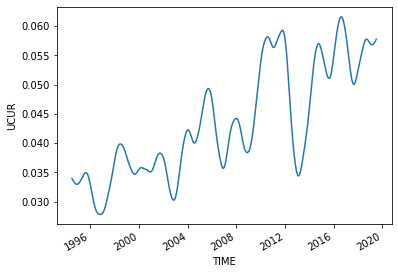

In [31]:
%store -r
EKE_S = xr.DataArray.from_series(EKE_S_filtered)
EKE_S.plot()

In [32]:
x = EKE_S.sel(TIME=slice('1995-01-01','2017-03-17')).values
y = BMP_filt_anomalies.sel(time=slice('1995-01-01','2017-03-17')).values

In [33]:
r, p = stats.pearsonr(x, y)
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: 0.5892321944831177 and p-value: 0.0
